# Trying to train UNet with L1 loss

In [ ]:
!pip install scikit-image
!pip install IProgress
!pip install jupyter
!pip install ipywidgets widgetsnbextension pandas-profiling

In [2]:
!jupyter nbextension enable --py widgetsnbextension
import torch
import torch.utils.data as data
from python.data.dataset import *
from python.models.generator import UNet
from python.models.discriminator import PatchGAN
from python.utils.images import *
from python.train.trainer import *
from tqdm.notebook import tqdm

import sys

SEED = 42
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

log = open("train.log", "a")
sys.stdout = log

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
dataset = "data/Coco"
version = "2017"

In [6]:
def init_weight(m): # https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
            
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


dataset_train = CocoLab(dataset, version=version, size=256, train=True)
trainloader = data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)

dataset_test = CocoLab(dataset, version=version, size=256, train=False)
testloader = data.DataLoader(dataset_test, batch_size=4, shuffle=True, num_workers=4)

generator = UNet(1, 2, stochastic=False).to(device)

generator.apply(init_weight) # init weights with a gaussian distribution centered at 0, and std=0.02

UNet(
  (model): Sequential(
    (0): UNetModule(
      (inner_module): UNetModule(
        (inner_module): UNetModule(
          (inner_module): UNetModule(
            (inner_module): UNetModule(
              (inner_module): UNetModule(
                (inner_module): UNetModule(
                  (inner_module): UNetModule(
                    (down): Down(
                      (down): Sequential(
                        (0): LeakyReLU(negative_slope=0.2, inplace=True)
                        (1): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
                      )
                    )
                    (up): Up(
                      (up): Sequential(
                        (0): ReLU(inplace=True)
                        (1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
                        (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                      )
                    

In [11]:
num_epochs = 2

  0%|          | 0/252 [00:00<?, ?batch/s]

  0%|          | 0/252 [00:00<?, ?batch/s]

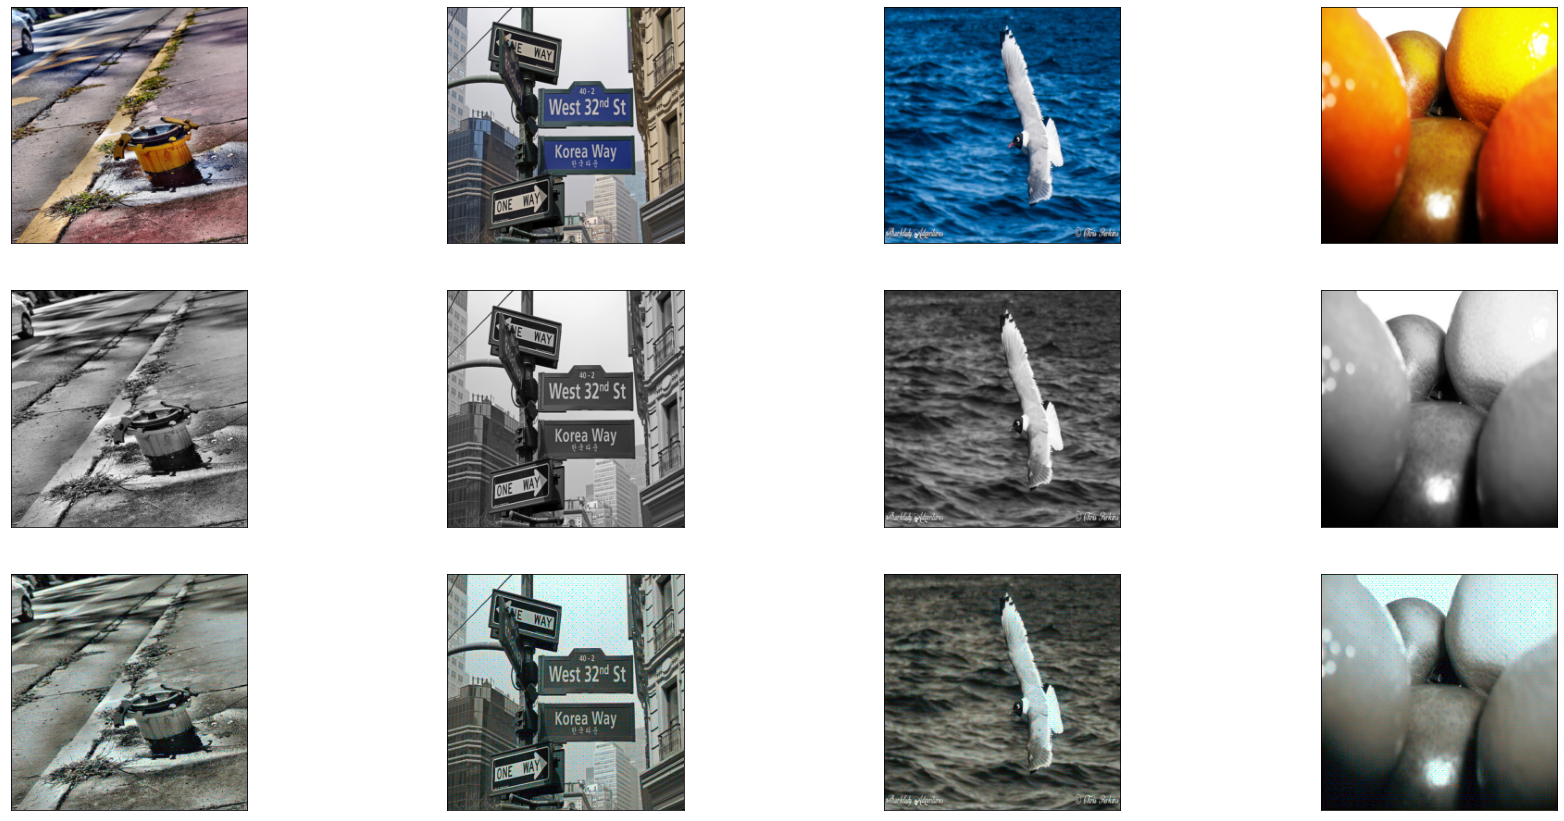

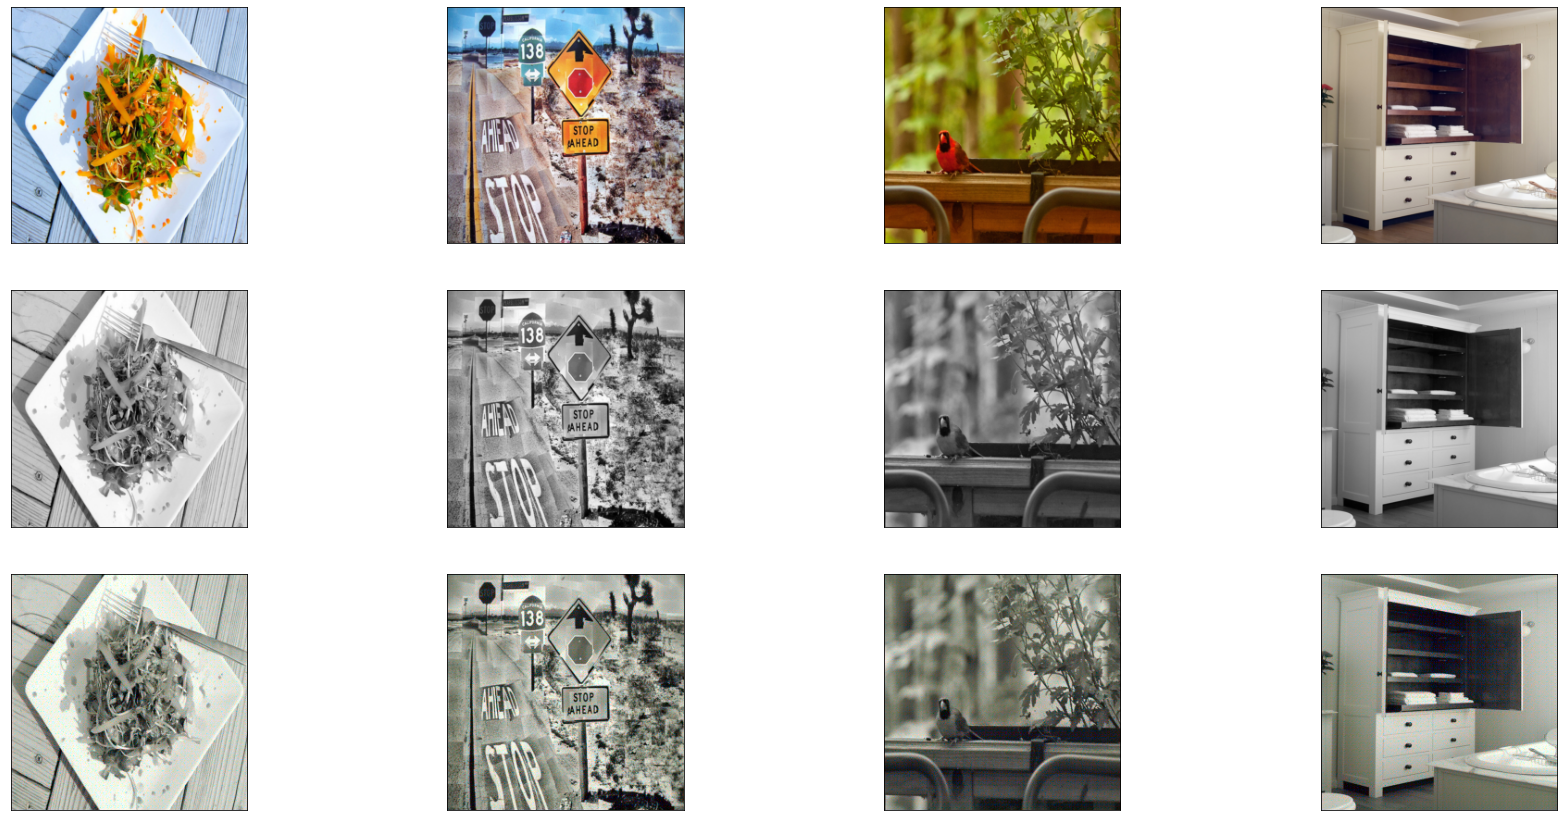

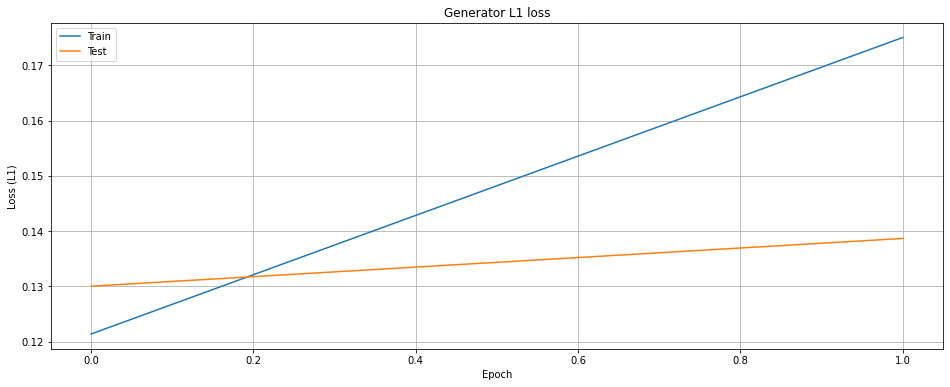

In [12]:
generator.train()

LEARNING_RATE = 0.0002

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

train_avg_loss = []
test_avg_loss = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    
    with tqdm(trainloader, unit="batch") as tepoch:
        for L, ab in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            L = L.to(device)
            ab = ab.to(device)
            pred = generator(L)
            loss = criterion(pred, ab)

            train_losses.append(loss.detach().to("cpu"))
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():   
            # Do not set .eval()
            for L, ab in testloader:
                L = L.to(device)
                ab = ab.to(device)

                pred = generator(L)
                loss = criterion(pred, ab)
                test_losses.append(loss.detach().to("cpu"))

            train_avg_loss.append(torch.mean(torch.Tensor(train_losses)))
            test_avg_loss.append(torch.mean(torch.Tensor(test_losses)))

            print('[Epoch {}/{}] '.format(epoch+1, num_epochs) +
                    'train_loss: {:.4f} - '.format(train_avg_loss[-1]) +
                    'test_loss: {:.4f}'.format(test_avg_loss[-1]))

            multi_plot(testloader, generator, "figures/pretrain_epoch_{}.png".format(epoch+1), columns=4)
            torch.save(generator.state_dict(), "saved_models/generator_pretrain")


plt.figure(figsize=(16, 6))
plt.title('Generator L1 loss')
plt.plot(train_avg_loss)
plt.plot(test_avg_loss)
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')
plt.savefig("figures/pretrain_Generator.png")